In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import time

AttributeError: property 'format' of 'fast_csr_matrix' object has no setter

# Implementing inhomogeneous broadening in QuTiP

How to do low frequency dephasing in qutip? 

A $\sigma_z$ collapse operator will cause dephasing, but the dephasing is perfectly stochastic (uncorrelated) and therefore had a white noise spectrum.  Because of this, it is impossible to illustrate the improvement of the coherence time when performing a spin-echo sequence, for example.

A special and common type of dephasing is low-frequency noise, which is much slower than the pulse sequence, but much faster than the averaging time in the experiment. 

For this type of noise, you can approximate that the dephasing noise causes a static offset in the frequency for the different pulse sequences that you average together. This is often called  "inhomogeneous broadening", a term borrowed from the community of NMR, where a similar type of broadening occurs due to inhomegeneity in the magnetic field that the spin ensemble is experiencing. 

The question is: how to implement this in QuTiP? 

What we need to do is to run `mesolve()` a bunch of different times while each time picking the qubit frequency from a (say)  Gaussian distribution. Then the "experimental" data is determined by (classically)  averaging all of the results.

It  would be great if we could do this in a vectorised way, but I don't see a way to do that so easily.  Therefore, we will first try the braindead thing and just run `mesolve()` in a for loop...

I  will check this by looking at the time evolution of $\langle \sigma_x \rangle$ for a superposition state.

## First: Just normal phase evolution

In [ ]:
N = 2
psi0 = (basis(N,0) + basis(N,1))/np.sqrt(2)
w  = 2*np.pi
H = 0.5*w*sigmaz()
t = np.linspace(0, 10, 401) 
result = mesolve(H, psi0, t, c_ops = [], e_ops = [sigmax()])
plt.plot(t,result.expect[0][:])

Let's code this into a function

In [ ]:
Nt = 401
def do_calc(w):
    N = 2
    psi0 = (basis(N,0) + basis(N,1))/np.sqrt(2)
    H = 0.5*(2*np.pi*w)*sigmaz()
    t = np.linspace(0, 10, Nt) 
    result = mesolve(H, psi0, t, c_ops = [], e_ops = [sigmax()])
    return t,result.expect[0][:]

In [ ]:
t,r = do_calc(1)
t,r2 = do_calc(1.1)
plt.plot(t,r)
plt.plot(t,r2)

OK, good, I think we are ready to go.

## Inhomogeneous broadening

First, create a distribution of frequencies:

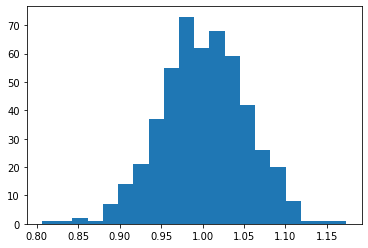

In [63]:
Nw = 500
w =  np.random.normal(loc=1,scale=0.05,size=Nw)
plt.hist(w,bins=20);               

Now run the simulation for each entry, storing the results in a 2D array:

In [64]:
t0 = time.time()
all_results = np.zeros([Nt,Nw])
for i in range(Nw):
    t,r = do_calc(w[i])
    all_results[:,i] = r
print("Time elapsed: %.1f seconds" % (time.time()-t0))

Time elapsed: 36.8 seconds


In [65]:
average_result = np.average(all_results,axis=1)

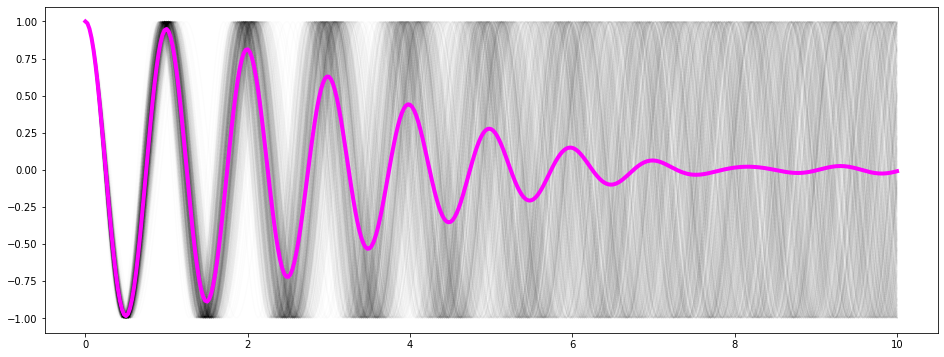

In [67]:
plt.figure(figsize=(16,6))
plt.plot(t,all_results,c='k',alpha=0.01);
plt.plot(t,average_result, c='magenta', lw=4)

Note that as you increase the inhomogeneous broadening, you need to increase the number of ensemble members to capture the correct averaged response. For example, if I use a deviation of 5% for the frequency but take only 100 ensemble members, then I don't get the correct suppression of the oscillations at longer times.

Time elapsed: 7.2 seconds


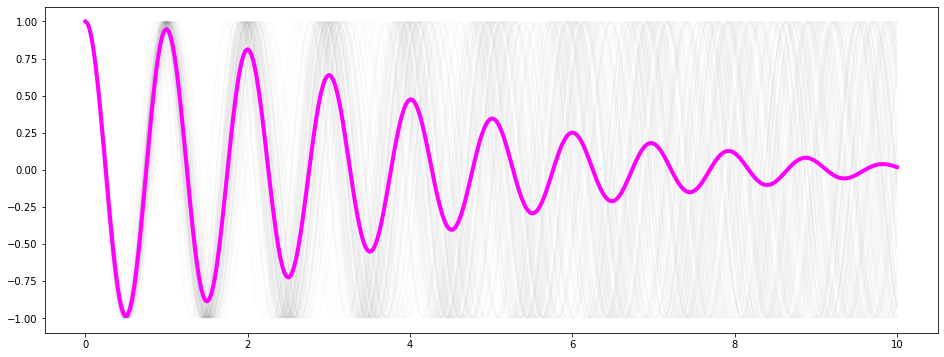

In [69]:
Nw = 100
w =  np.random.normal(loc=1,scale=0.05,size=Nw)

t0 = time.time()
all_results = np.zeros([Nt,Nw])
for i in range(Nw):
    t,r = do_calc(w[i])
    all_results[:,i] = r
print("Time elapsed: %.1f seconds" % (time.time()-t0))

average_result = np.average(all_results,axis=1)

plt.figure(figsize=(16,6))
plt.plot(t,all_results,c='k',alpha=0.01);
plt.plot(t,average_result, c='magenta', lw=4)